In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score

from skimage.morphology import closing, disk, square
from tools import *

In [2]:
indiana_img = np.load('../data/indianapines.npy')
indiana_labels = np.load('../data/indianapines_gt.npy')
salinas_img = np.load('../data/salinas.npy')
salinas_labels = np.load('../data/salinas_gt.npy')

In [3]:
# normalize radiance values to get reflectance values
indiana_img = indiana_img / indiana_img.max()
salinas_img = salinas_img / salinas_img.max()

In [4]:
print("Indiana shape: {}".format(indiana_img.shape))
print("Salinas shape: {}".format(salinas_img.shape))

Indiana shape: (145, 145, 200)
Salinas shape: (512, 217, 204)


In [5]:
X_indiana = indiana_img.reshape((-1, indiana_img.shape[-1])) # reshaping the HSI as a 2D matrix
print("Indiana shape: {}".format(X_indiana.shape))

X_salinas = salinas_img.reshape((-1, salinas_img.shape[-1])) # reshaping the HSI as a 2D matrix
print("Salinas shape: {}".format(X_salinas.shape))

Indiana shape: (21025, 200)
Salinas shape: (111104, 204)


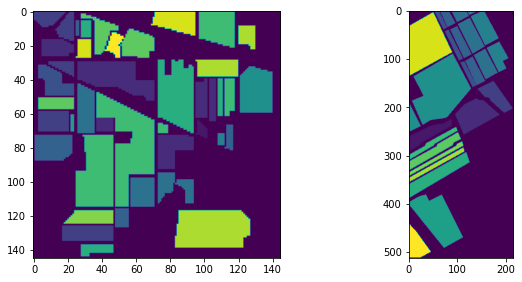

In [6]:
plot_two_figures(indiana_labels, salinas_labels, '', '')

 ## PCA

In [7]:
def get_number_components(X):
    # first PCA with by keeping all features
    print("Fitting the PCA")
    pca_model = PCA()
    pca_model.fit(X)
    var_cumsum = pca_model.explained_variance_ratio_.cumsum()
    return len(var_cumsum[var_cumsum <= 0.9991])

def extract_features(X, n_components):
    pca_model = PCA(n_components=n_components)
    pca_model.fit(X)
    return pca_model.transform(X)

In [8]:
n_components_indiana = get_number_components(X_indiana)
n_components_salinas = get_number_components(X_salinas)

Fitting the PCA
Fitting the PCA


In [9]:
print("Number of components Indiana: {}".format(n_components_indiana))
print("Number of components Salinas: {}".format(n_components_salinas))

Number of components Indiana: 69
Number of components Salinas: 6


In [10]:
X_indiana_reduced = extract_features(X_indiana, n_components_indiana)
X_salinas_reduced = extract_features(X_salinas, n_components_salinas)

In [11]:
print("Indiana reduced data shape: {}".format(X_indiana_reduced.shape))
print("Salinas reduced data shape: {}".format(X_salinas_reduced.shape))

Indiana reduced data shape: (21025, 69)
Salinas reduced data shape: (111104, 6)


## GMM

In [12]:
n_cluster_indiana = len(np.unique(indiana_labels)) - 1
n_cluster_salinas = len(np.unique(salinas_labels)) - 1

In [13]:
print("Number of labels Indiana: {}".format(n_cluster_indiana))
print("Number of labels Salinas: {}".format(n_cluster_salinas))

Number of labels Indiana: 16
Number of labels Salinas: 16


In [14]:
indiana_model = GaussianMixture(n_components=n_cluster_indiana, verbose=1)
salinas_model = GaussianMixture(n_components=n_cluster_salinas, verbose=1)

In [15]:
indiana_model.fit(X_indiana_reduced)

Initialization 0
  Iteration 10
Initialization converged: True


GaussianMixture(n_components=16, verbose=1)

In [16]:
salinas_model.fit(X_salinas_reduced)

Initialization 0
  Iteration 10
  Iteration 20
Initialization converged: True


GaussianMixture(n_components=16, verbose=1)

In [42]:
indiana_preds = indiana_model.predict(X_indiana_reduced)
salinas_preds = salinas_model.predict(X_salinas_reduced)

In [44]:
indiana_preds = indiana_preds.reshape((indiana_img.shape[0], indiana_img.shape[1]))
salinas_preds = salinas_preds.reshape((salinas_img.shape[0], salinas_img.shape[1]))

In [76]:
# apply morphologie
closing_indiana_preds = closing(indiana_preds, square(3))
closing_salinas_preds = closing(salinas_preds, square(3))

In [77]:
final_indiana_preds = remove_unclassified(closing_indiana_preds, indiana_labels)
final_salinas_preds = remove_unclassified(closing_salinas_preds, salinas_labels)

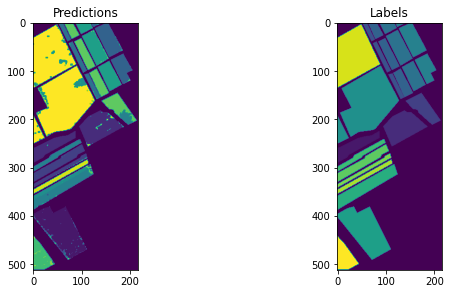

In [78]:
plot_two_figures(final_salinas_preds, salinas_labels, 'Predictions', 'Labels')

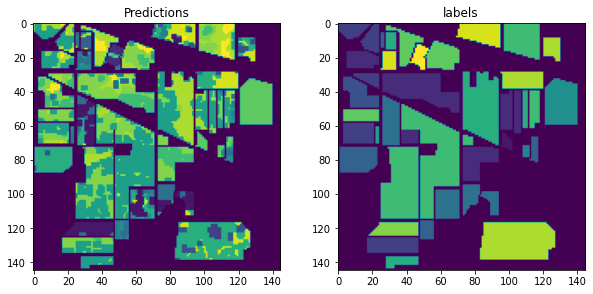

In [79]:
plot_two_figures(final_indiana_preds, indiana_labels, 'Predictions', 'labels')

In [80]:
salinas_labels_flatten = salinas_labels.flatten()
final_preds_flatten = final_salinas_preds.flatten()

test = salinas_labels_flatten[~(salinas_labels_flatten==0)]
test2 = final_preds_flatten[~(final_preds_flatten==0)]

adjusted_rand_score(test, test2)

0.6564885976147504

In [81]:
indiana_labels_flatten = indiana_labels.flatten()
final_preds_flatten = final_indiana_preds.flatten()

test = indiana_labels_flatten[~(indiana_labels_flatten==0)]
test2 = final_preds_flatten[~(final_preds_flatten==0)]

adjusted_rand_score(test, test2)

0.25268707591094647

In [284]:
X_salinas_reduced.shape

(111104, 6)

In [285]:
c = np.cov(X_salinas_reduced.T)

In [286]:
c.shape

(6, 6)

In [287]:
inv_c = np.linalg.inv(c)

In [289]:
res = np.empty((X_salinas_reduced.shape))

for i in range(res.shape[0]):
    res[i] = X_salinas_reduced[i] @ inv_c @ X_salinas_reduced[i]

In [290]:
res = np.abs(res)

In [291]:
res.shape

(111104, 6)

In [296]:
tmp = res.reshape((salinas_img.shape[0], salinas_img.shape[1], 6))

In [299]:
tmp.shape

(111104, 6)

In [298]:
plt.imshow(tmp[:, :, 3] > 250)
plt.show()
plt.imshow(X_salinas_reduced[:, :, 3])
plt.show()

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [114]:
x = np.linspace(-1,1,100)
y =  np.linspace(-1,1,100)
X, Y = np.meshgrid(x,y)

In [134]:
test_img = indiana_img[:, :, 40]

In [190]:
outliers_idx_x = np.random.randint(0, test_img.shape[0], 300)
outliers_idx_y = np.random.randint(0, test_img.shape[1], 300)

In [191]:
print(outliers_idx_x[:10])
print(outliers_idx_y[:10])

[  2 143  84  42  17 138  94   6  18  84]
[ 12  34 122 134  19   3  72  15  98 104]


In [192]:
outliers_idx = np.hstack((outliers_idx_x.reshape(-1, 1), outliers_idx_y.reshape(-1, 1)))

In [193]:
outliers_idx

array([[  2,  12],
       [143,  34],
       [ 84, 122],
       [ 42, 134],
       [ 17,  19],
       [138,   3],
       [ 94,  72],
       [  6,  15],
       [ 18,  98],
       [ 84, 104],
       [ 23,   0],
       [101,  76],
       [ 32,  74],
       [ 47,  39],
       [  9,  21],
       [ 89, 117],
       [129,   8],
       [ 90,  21],
       [124,  33],
       [ 32,   3],
       [  1,  34],
       [109,  70],
       [132,  61],
       [ 41, 139],
       [121,  47],
       [142,   7],
       [102,  71],
       [ 10,  55],
       [116,  47],
       [108,   5],
       [139,  74],
       [ 36, 133],
       [ 11, 143],
       [ 40,   9],
       [ 12,  70],
       [130, 115],
       [104,  95],
       [113,  78],
       [135,  18],
       [ 24,  91],
       [121,  49],
       [ 61,   0],
       [ 21,  47],
       [ 60,  96],
       [ 31,  71],
       [ 81,  65],
       [108,  22],
       [ 46,  54],
       [ 51,  65],
       [113, 125],
       [ 27,  90],
       [143,   9],
       [ 51,

In [210]:
res = np.meshgrid(outliers_idx_x, outliers_idx_y)

In [216]:
outliers_idx_x.shape

(300,)

In [217]:
res

[array([[  2, 143,  84, ..., 143, 104,  49],
        [  2, 143,  84, ..., 143, 104,  49],
        [  2, 143,  84, ..., 143, 104,  49],
        ...,
        [  2, 143,  84, ..., 143, 104,  49],
        [  2, 143,  84, ..., 143, 104,  49],
        [  2, 143,  84, ..., 143, 104,  49]]),
 array([[ 12,  12,  12, ...,  12,  12,  12],
        [ 34,  34,  34, ...,  34,  34,  34],
        [122, 122, 122, ..., 122, 122, 122],
        ...,
        [ 24,  24,  24, ...,  24,  24,  24],
        [ 26,  26,  26, ...,  26,  26,  26],
        [107, 107, 107, ..., 107, 107, 107]])]

In [269]:
test_img_outliers = test_img.copy()
for i in range(300):
    test_img_outliers[outliers_idx_x[i], outliers_idx_y[i]] = 0.0

In [270]:
test_img.shape

(145, 145)

In [271]:
img_idx = []
img_val = []
for i in range(test_img.shape[0]):
    for j in range(test_img.shape[1]):
        if [i, j] in outliers_idx.tolist():
            continue
        img_idx.append([i, j])
        img_val.append(test_img[i, j])
img_idx = np.array(img_idx)
img_val = np.array(img_val)

In [272]:
img_idx.shape

(20726, 2)

In [273]:
outliers_idx.shape

(300, 2)

In [274]:
img_val.shape

(20726,)

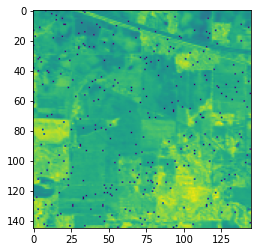

In [275]:
plt.imshow(test_img_outliers)

In [277]:
def process_value(v):
    '''
    process one value
    scale the value in the range of [0, 255]
    '''
    return 255 if v > 255 else 0 if v < 0 else v

def process_pos(x, y, size):
    return ((x % size) + size) % size, ((y % size) + size) % size

def convolution_pos(mat, kernel, i, j):
    size = len(mat)
    n = len(kernel)
    cpt = 0
    for k in range(n):
        for z in range(n):
            x, y = i - n // 2 + k, j - n // 2 + z
            x, y = process_pos(x, y, size)
            cpt += kernel[k][z] * mat[x][y]
    mat[i][j] = cpt

In [283]:
outliers_idx.shape

(300, 2)

In [278]:
conv_test_img = test_img_outliers.copy()

In [279]:
kernel = np.ones((3,3)) * 1/9.

for pos in outliers_idx:
    convolution_pos(conv_test_img, kernel, pos[0], pos[1])

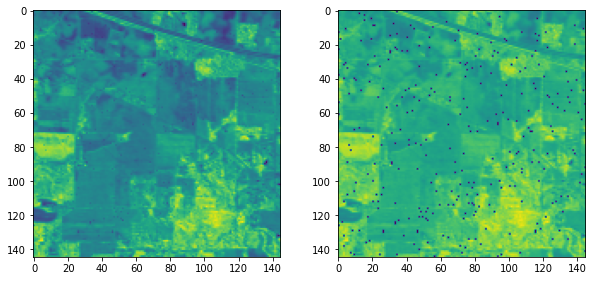

In [280]:
plot_two_figures(conv_test_img, test_img_outliers, '', '')

In [149]:
outliers_vals

array([0.6059975 , 0.6851312 , 0.560808  , 0.58860891, 0.73594336,
       0.71480633, 0.55581008, 0.72636401, 0.74677218, 0.73042482,
       0.55102041, 0.89546022, 0.51187005, 0.57205331, 0.59683465,
       0.45189504, 0.5590379 , 0.52738442, 0.61234902, 0.56955435,
       0.68794252, 0.65097876, 0.59870887, 0.63379842, 0.59443982,
       0.4664723 , 0.79623074, 0.60391504, 0.55955852, 0.71438984,
       0.5952728 , 0.58236152, 0.55237401, 0.48802582, 0.73438151,
       0.60474802, 0.56341108, 0.69731362, 0.6940858 , 0.62484382,
       0.74042066, 0.72865473, 0.58517284, 0.61380675, 0.59037901,
       0.59475219, 0.68190337, 0.57340691, 0.51905456, 0.59673053,
       0.52655144, 0.59423157, 0.66722199, 0.59058726, 0.53810912,
       0.60276968, 0.60224906, 0.5635152 , 0.54779259, 0.68502707,
       0.70574761, 0.58236152, 0.79529363, 0.64296127, 0.64233653,
       0.76020408, 0.62099125, 0.70866306, 0.55403998, 0.75218659,
       0.90326947, 0.65660142, 0.69450229, 0.60183257, 0.64244

In [119]:
from scipy.interpolate import griddata

In [218]:
interp_res = griddata(img_idx, img_val, (res[0], res[1]))

In [219]:
interp_res.shape

(300, 300)

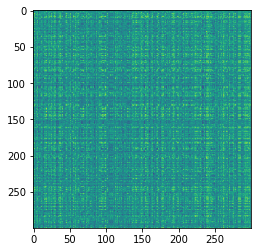

In [220]:
plt.imshow(interp_res)

TypeError: Invalid shape (300,) for image data

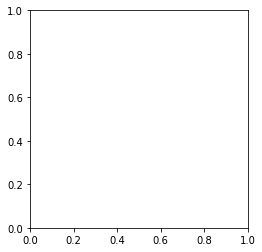

In [208]:
interp_test_img = test_img_outliers.copy()
for i in range(300):
    idx = outliers_idx[i]
    interp_test_img[idx[0], idx[1]]

In [221]:
def func(x, y):
    return x*(1-x)*np.cos(4*np.pi*x) * np.sin(4*np.pi*y**2)**2

In [222]:
grid_x, grid_y = np.mgrid[0:1:100j, 0:1:200j]

In [227]:
grid_x.shape

(100, 200)

In [225]:
grid_y.shape

(100, 200)

In [228]:
points = np.random.rand(1000, 2)
points.shape

(1000, 2)

In [229]:
values = func(points[:,0], points[:,1])
values.shape

(1000,)

In [230]:
grid_z0 = griddata(points, values, (grid_x, grid_y), method='nearest')

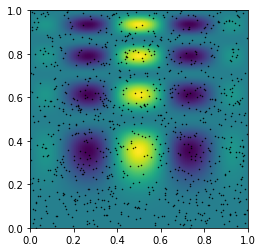

In [244]:
plt.imshow(func(grid_x, grid_y).T, extent=(0,1,0,1), origin='lower')
plt.plot(points[:,0], points[:,1], 'k.', ms=1)

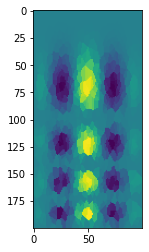

In [232]:
plt.imshow(grid_z0.T)

In [245]:
np.mgrid[0:1:100j, 0:1:200j]

array([[[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.01010101, 0.01010101, 0.01010101, ..., 0.01010101,
         0.01010101, 0.01010101],
        [0.02020202, 0.02020202, 0.02020202, ..., 0.02020202,
         0.02020202, 0.02020202],
        ...,
        [0.97979798, 0.97979798, 0.97979798, ..., 0.97979798,
         0.97979798, 0.97979798],
        [0.98989899, 0.98989899, 0.98989899, ..., 0.98989899,
         0.98989899, 0.98989899],
        [1.        , 1.        , 1.        , ..., 1.        ,
         1.        , 1.        ]],

       [[0.        , 0.00502513, 0.01005025, ..., 0.98994975,
         0.99497487, 1.        ],
        [0.        , 0.00502513, 0.01005025, ..., 0.98994975,
         0.99497487, 1.        ],
        [0.        , 0.00502513, 0.01005025, ..., 0.98994975,
         0.99497487, 1.        ],
        ...,
        [0.        , 0.00502513, 0.01005025, ..., 0.98994975,
         0.99497487, 1.        ],
        [0. 

In [246]:
from scipy import interpolate

In [247]:
xnew = np.arange(-5.01, 5.01, 1e-2)
xnew.shape

(1002,)

In [249]:
ynew = np.arange(-5.01, 5.01, 1e-2)

In [251]:
xx, yy = np.meshgrid(x, y)

In [254]:
z = np.sin(xx**2+yy**2)

In [256]:
z

array([[0.90929743, 0.92520997, 0.93936308, ..., 0.93936308, 0.92520997,
        0.90929743],
       [0.92520997, 0.93964268, 0.95232376, ..., 0.95232376, 0.93964268,
        0.92520997],
       [0.93936308, 0.95232376, 0.96354316, ..., 0.96354316, 0.95232376,
        0.93936308],
       ...,
       [0.93936308, 0.95232376, 0.96354316, ..., 0.96354316, 0.95232376,
        0.93936308],
       [0.92520997, 0.93964268, 0.95232376, ..., 0.95232376, 0.93964268,
        0.92520997],
       [0.90929743, 0.92520997, 0.93936308, ..., 0.93936308, 0.92520997,
        0.90929743]])

In [257]:
f = interpolate.interp2d(x, y, z, kind='cubic')

In [259]:
print(f)